# Introduction

Unsupervised learning techniques like UMAP and T-SNE are powerful tools for handling high-dimensional data.

However, their performance and usefulness rely on the parameters that the user inputs; the choice of parameters can make a huge difference in the output of the model. To get a better grasp on the outcome of the model, we can use parameter grids. This provides a clearer understanding of how the model behaves with different parameters.

In this post, I will show you how I use these grids and hope that you can apply them to your projects as well.


In [54]:
# | code-fold: hide

import warnings
from functools import lru_cache
from typing import Union

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.preprocessing import StandardScaler, minmax_scale

In [63]:
# | code-fold: hide

set_matplotlib_formats("svg")
sns.set_style("darkgrid")
sns.set_context(context="notebook", font_scale=1.5)


warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

FIGSIZE = (12, 6)
N_SAMPLES = 100

# Dataset: Penguin

For this notebook, I have taken inspiration from the [UMAP docs](https://umap-learn.readthedocs.io/en/latest/basic_usage.html#penguin-data) and loaded the penguin dataset. The dataset contains measurements for 344 penguins. There are three different species of penguins in this dataset. Some preprocessing is applied to the dataset to make it suitable for the UMAP model. We retain the numerical columns and drop everything that contains a NaN value; afterwards, we apply a standard scaler to the data, ensuring that all numerical values are more or less on the same scale.


![penguins](https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/man/figures/lter_penguins.png) “Artwork by @allison_horst”


In [64]:
# | code-fold: show

# load penguin data
penguins = pd.read_csv(
    "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv"
)

# select numeric columns
penguin_data = penguins[
    [
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
]

# drop rows with missing values, umap doens't handle them
# apply standard scaling, to get numeric values on the same scale
penguin_data = penguin_data.dropna()
scaled_penguin_data = StandardScaler().fit_transform(penguin_data.to_numpy())


colors = penguins.loc[penguin_data.index, "species"]

# Applying UMAP

UMAP is a general-purpose manifold learning and dimension reduction algorithm. It takes a high-dimensional dataset and reduces it to a lower-dimensional space, most of the time to two dimensions, which enables easy plotting. However, it can be set to any number of dimensions. The strength of UMAP lies in its ability to capture the structure of the data in a way that allows for meaningful interpretation about the data. also umap scales better with large datasets compared to t-sne, another popular dimensionality reduction technique.


In [67]:
# | code-fold: show
@lru_cache(maxsize=None)
def create_embedding_from_params(
    n_neighbors: int = 15,
    min_dist: float = 0.1,
) -> np.ndarray:
    """create penguin embeddings using umap

    takes the input parameters and creates a umap embedding

    Parameters
    ----------
    n_neighbors : int, optional
        The size of local neighborhood used for manifold approximation, by default 15
    min_dist : float, optional
        The effective minimum distance between embedded points, by default 0.1

    Returns
    -------
    np.ndarray
        emdedding of the penguin data
    """
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        n_jobs=-1,
        random_state=42,
    )
    return minmax_scale(reducer.fit_transform(scaled_penguin_data))


def plot_embedding(
    embedding: np.ndarray,
    n_neighbors: int,
    min_dist: float,
    ax: plt.Axes,
):
    """create a scatter plot of the embedding

    creates a scatter plot of the penguin dataset using the embedding and uses the input parameters as title

    Parameters
    ----------
    embedding : np.ndarray
        umap embeddings of the penguin data
    n_neighbors : int
        number of neighbors used for the umap embedding
    min_dist : float
        minimum distance between points in the embedding
    ax : plt.Axes
        axes object to plot on
    """
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=colors,
        ax=ax,
        s=10,
        legend=False,
    )
    ax.set_title(f" {n_neighbors=} and {min_dist=} ")
    ax.set_xticks(np.linspace(0, 1, 6))
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_xticklabels([])
    ax.set_yticklabels([])


def create_param_grid(n_neighbors_vals, min_dist_vals):
    fig, ax = plt.subplots(
        len(n_neighbors_vals),
        len(min_dist_vals),
        figsize=(18, 10),
    )

    # look over all parameter combinations
    for i, n_neighbors in enumerate(n_neighbors_vals):
        for j, min_dist in enumerate(min_dist_vals):
            embedding = create_embedding_from_params(n_neighbors, min_dist)
            plot_embedding(embedding, n_neighbors, min_dist, ax=ax[i, j])

    # final cleanup
    fig.suptitle("UMAP embeddings with different n_neighbors and min_dist")
    fig.supxlabel("min_dist ->")
    fig.supylabel("n_neighbors ->")
    plt.tight_layout()
    plt.show()

Two helper functions are defined to create the parameter grids. the first function, `create_embedding_from_params` takes the two parameters as inputs and returns the umap embedding of the dataset. The second function, `plot_embedding` takes the embedding and the parameters and an matplotlib axes object and plots the embedding on the axes object.
the last functions marries all together and creates a grid of plots for the different parameters.


# Umap Parameters

to keep things simple we are going to use a parameter grid with two parameters: `n_neighbors` and `min_dist`. `n_neighbors` is the number of neighbors used to construct the fuzzy topological representation of the data. `min_dist` is the minimum distance between points in the low-dimensional representation. The higher the value of `n_neighbors`, the more global the structure will be. The higher the value of `min_dist`, the more separated the clusters will be.
lets see if this also happens in practise.


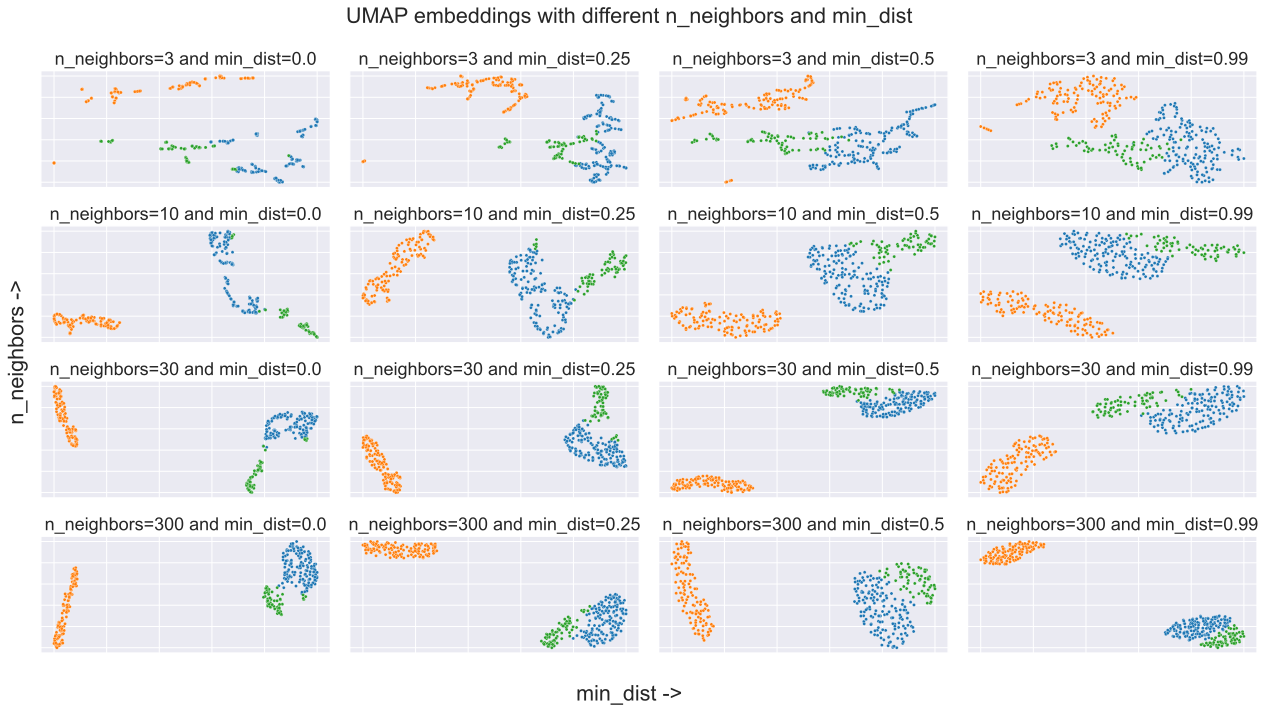

In [69]:
# | code-fold: show

# define the pramgrid
n_neighbors_vals = (3, 10, 30, 300)
min_dist_vals = (0.0, 0.25, 0.5, 0.99)
create_param_grid(n_neighbors_vals, min_dist_vals)

it the plot above we have two axis: the x axes represents the `min_dist` parameter with on the left the small values and on the right to larger values


# Bonus: interactive parameter grid
